**SD5 - 1908 Messina event: a test case for adding landslide sources to the PTF**   
On December 28, 1908, an earthquake of an estimated magnitude Mw of 7.1 occurred near Messina, offshore East Sicily. The earthquake triggered a tsunami of several meters and caused at least 60,000 fatalities. The exact cause of the 1908 tsunami is not fully understood, and both earthquake and landslide source contributions provide alternative or complementary explanations.   
   
In this notebook, we use the 1908 Messina event as a test case for the mini-workflow that embeds landslide sources into the PTF.   
Before running the workflow, we precomputed the possible landslide release volumes in the area of interest, ran the numerical simulations of landslide dynamics for each release volume with the code BingClaw, followed by the numerical simulations of tsunami propagation with the code Tsunami-HySEA.    
    
The mini-workflow in this notebook follows these steps:
1. Run the first step of the PTF that generates an ensemble of earthquake scenarios and associated probabilities
2. Compute the peak ground acceleration (PGA) for each earthquake scenario (shakemaps)
3. Compute the probabilities of each precomputed release volume based on the PGA and the probability of each earthquake scenario
4. Retrieve the maximum inundation heights (MIH) from the precomputed simulations database, aggregate the probabilities, and visualize the results.
    
*See the README file for info on requirements to run the notebook and where to download the input files*

In [1]:
import os
import numpy as np
from scipy.stats import norm
from scipy.interpolate import interp1d
import json
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets

import ewricagm.gm_mapping as GMmap

In [2]:
### Set paths of input and output directories
# path of the main input folder (downloaded from the Simulation Data Lake)
input_folder = r"P:\2022\02\20220296\Delivery-Result\input-landslide-workflow-sd5\\"
# ptf input data folder
data_folder = os.path.join(input_folder, "ptf-input")  
# precomputed database input folder
database_folder = os.path.join(input_folder, "precomputed-database")
# output folder
output_folder = 'output'

# Load external functions
%run ./utils/ptf_functions.ipynb
%run ./utils/ptf_functions_sampling.ipynb
%run ./utils/workflow_functions.py

### **1. Run step 1 of the PTF**   
This step create an ensemble of earthquake scenarios with different source parameters and associated probabilities

In [3]:
### Input parameters for the PTF
event_file_name = '1908_1228_messina.json'
workdir = './'
sigma = 1.1
sigma_inn = sigma
sigma_out = sigma + 0.5
negligible_prob = 2*norm.cdf(-1. * sigma)
sampling_nscenarios = 200

In [4]:
### Load the event file and build the event dictionary
event_file = os.path.join(data_folder, event_file_name)
s = open(event_file, 'r').read()
jsn_object = eval(s)

event_dict = int_quake_cat2dict(json_object=jsn_object)

event_dict['event_file'] = event_file
event_dict['sigma'] = sigma

event_dict = compute_position_sigma_lat_lon(event_dict)
print(event_dict)

{'eventid': '19081228', 'originid': '19081228', 'lat': 37.965, 'lon': 15.487, 'depth': 15.0, 'ot': '1908-12-28T04:20', 'mag': 7.09, 'mag_percentiles': {'p16': 6.89, 'p50': 7.09, 'p84': 7.29}, 'MagSigma': 0.20000000000000018, 'type': 'earthquake', 'mag_type': 'Mwp', 'ee_utm': (542777.7386262032, 4202043.550189212, 33, 'S'), 'place': 'east_sicily', 'cov_matrix': {'XX': 13.9478, 'XY': 4.8435, 'XZ': 0.2781, 'YY': 18.1122, 'YZ': 0.1786, 'ZZ': 10.2529}, 'pos_Sigma': {'XX': 13947800.0, 'XY': 4843500.0, 'XZ': 278100.0, 'YY': 18112200.0, 'YZ': 178600.0, 'ZZ': 10252900.0}, 'ee_PosCovMat_2d': array([[13.9478,  4.8435],
       [ 4.8435, 18.1122]]), 'PosMean_2d': array([ 542777.7386262 , 4202043.55018921]), 'PosCovMat_3d': array([[13.9478,  4.8435,  0.2781],
       [ 4.8435, 18.1122,  0.1786],
       [ 0.2781,  0.1786, 10.2529]]), 'PosCovMat_3dm': array([[13947800.,  4843500.,   278100.],
       [ 4843500., 18112200.,   178600.],
       [  278100.,   178600., 10252900.]]), 'PosMean_3d': array([ 542

Total number of POIs: 1107


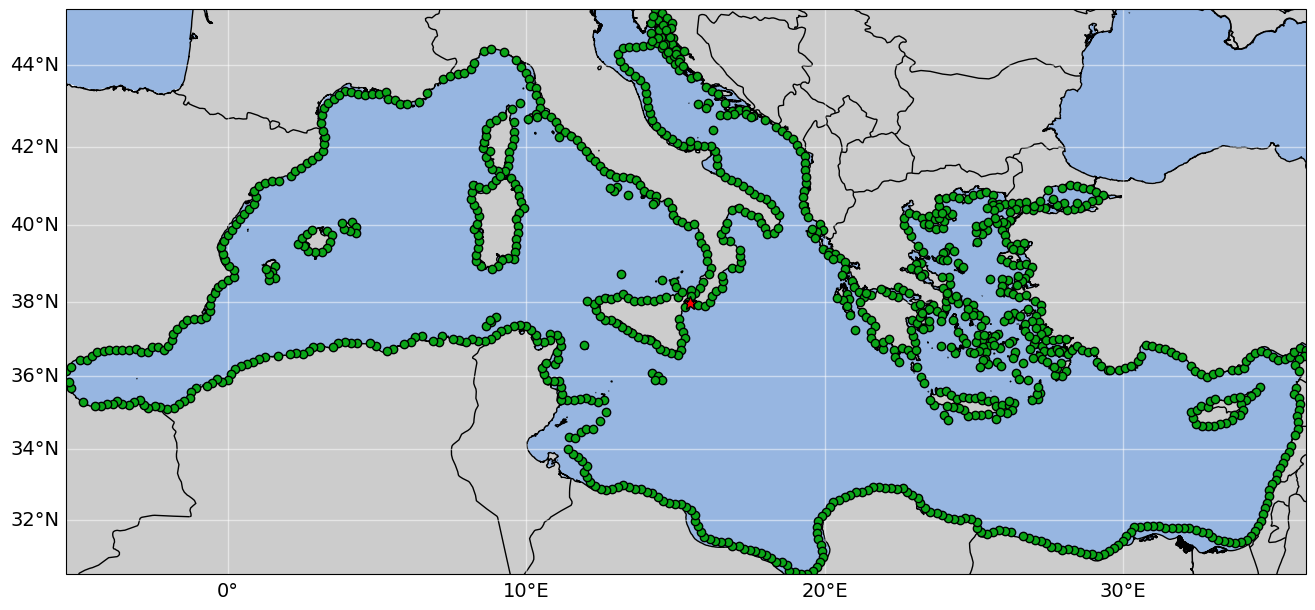

In [5]:
### Load file with coordinates of Points of Interests (POIs) and plot POIs locations
pois = np.load(os.path.join(data_folder,'pois_messina_ptf.npy'), allow_pickle=True).item()
n_pois = len(pois['pois_coords'])
print(f'Total number of POIs: {n_pois}')

pois_coords = pois['pois_coords']
pois_index = np.arange(n_pois)
plot_pois(pois_coords, pois_index, event_dict)

In [6]:
### Load input data from long term database
thresholds, intensity_measure = load_intensity_thresholds(data_folder)

LongTermInfo = dict()
LongTermInfo['Regionalization'] = np.load(os.path.join(data_folder, 'regionalization.npy'), allow_pickle=True).item()
LongTermInfo['Discretizations'] = np.load(os.path.join(data_folder,  'discretizations.npy'), allow_pickle=True).item()
LongTermInfo['Model_Weights'] =  load_Model_Weights(data_folder)
Region_files = load_region_files( LongTermInfo['Regionalization']['Npoly'], LongTermInfo['Regionalization']['Ttypes'], data_folder)
Mesh = np.load(os.path.join(data_folder,'mesh_files', 'slab_meshes_mediterranean.npy'), allow_pickle=True).item()
PSBarInfo = np.load(os.path.join(data_folder, 'PSBarInfo.npy'), allow_pickle=True).item()

In [7]:
### Find BS and PS scenarios from long term database that are relevant for this event and compute the probability of each scenario
ellipses = build_ellipsoid_objects(event_dict, sigma_inn, sigma_out)
LongTermInfo, PSBarInfo = conversion_to_utm(LongTermInfo, event_dict, PSBarInfo)

# Separation BS/PS
lambda_bsps = load_lambda_BSPS(sigma, event_dict, data_folder)
lambda_bsps = separation_lambda_BSPS(event_dict, lambda_bsps, LongTermInfo, Mesh)

# Pre-selection of scenarios
pre_selection = pre_selection_of_scenarios(sigma, event_dict, LongTermInfo, PSBarInfo, ellipses)

# Compute probabilities
short_term_probability  = short_term_probability_distribution(event_dict, negligible_prob, LongTermInfo, PSBarInfo, lambda_bsps, pre_selection)
probability_scenarios = compute_probability_scenarios(LongTermInfo, pre_selection, short_term_probability, Region_files)

 --> Volume of the Gaussian Ellipsoid: 1.56945730e+12 [m^3]
 --> N. Tetra in the Gaussian Ellipsoid: 402
 --> Volume of Tetra in the Gaussian Ellipsoid: 1.43228082e+12 [m^3]
 --> Volume difference Gaussian <--> Tetra: 8.74 [%]
 --> Distance between tetra and slabs:
     --> Min distance from slab HeA    328.846 [km]
         --> Nr of PS tetra with dist.  < 10.0 [km] from slab HeA : 0  (effective: 0)
         --> Nr of BS tetra with dist. >= 10.0 [km] from slab HeA : 402  (effective: 402)
     --> Min distance from slab CaA      4.928 [km]
         --> Nr of PS tetra with dist.  < 10.0 [km] from slab CaA : 153  (effective: 153)
         --> Nr of BS tetra with dist. >= 10.0 [km] from slab CaA : 249  (effective: 249)
     --> Min distance from slab CyA   1349.779 [km]
         --> Nr of PS tetra with dist.  < 10.0 [km] from slab CyA : 0  (effective: 0)
         --> Nr of BS tetra with dist. >= 10.0 [km] from slab CyA : 402  (effective: 402)
 --> lambda PS: 3.6904e-01  Volume PS: 5.5482e

In [8]:
### Sampling the ensemble to reduce the number of scenarios and update the probabilities (optional)
sampled_ensemble_SDE = compute_ensemble_sampling_SDE(LongTermInfo     = LongTermInfo,                                                                                                     negligible_prob  = negligible_prob,                                                                                                  pre_selection    = pre_selection,                                                                                                    regions          = Region_files,
                                                     short_term       = short_term_probability,
                                                     proba_scenarios  = probability_scenarios,
                                                     samp_scen        = sampling_nscenarios,
                                                     samp_type        = 'LH')

probability_scenarios = sampled_ensemble_SDE

Number of sampled BS scenarios: 123
Number of sampled PS scenarios: 0


In [9]:
### Save scenario lists (parameters and probabilities)
file_bs_list = os.path.join(output_folder, 'step1_BS_scenarios_list.txt')
file_bs_prob = os.path.join(output_folder, 'step1_BS_scenarios_prob.npy')

par_scenarios_bs = probability_scenarios['par_scenarios_bs']
len_scenarios_bs, len_pars = par_scenarios_bs.shape

fmt = "{:f}".format
with open(file_bs_list, 'w') as f_list_bs:
    for ic in range(len_scenarios_bs):
        pars = " ".join(fmt(par_scenarios_bs[ic, item]) for item in range(1, len_pars))
        ireg = "{:.0f}".format(par_scenarios_bs[ic, 0])
        f_list_bs.write("{:s} {:s} {:s}\n".format(str(ic+1), ireg, pars))

prob_scenarios_bs = probability_scenarios['ProbScenBS']
np.save(file_bs_prob, prob_scenarios_bs)

print('BS scenarios saved in: {}'.format(file_bs_list))
print('BS probabilities saved in: {}'.format(file_bs_prob))

BS scenarios saved in: output\step1_BS_scenarios_list.txt
BS probabilities saved in: output\step1_BS_scenarios_prob.npy


### **2. Create shakemaps for each PTF scenario**    
This step uses the earthquake source parameters from the list of scenarios generated by the step 1 of the PTF to compute a shakemap for each scenario.

In [10]:
### Convert the BS scenarios list into the required *.yaml file
path_to_csv = 'output/step1_BS_scenarios_list.txt'
yaml_path=convert_csv_to_yaml(path_to_csv)

Created YAML file: output/step1_BS_scenarios_list.yaml


In [11]:
### Run neural network to calculate the shakemaps
print('\nCalculating shapefunctions NN_MT:')
directory = os.path.dirname(yaml_path)
ensemblefile = yaml_path
config_path = 'ewricagm/configs/config_nn_mt.yaml'
GMmap.gm_mapping_read(ensemblefile, directory, config_path=config_path)
print('Finished calculating NN_MT.\n')


Calculating shapefunctions NN_MT:
31/31 [==============================] - 0s 7ms/step
Finished calculating NN_MT.



In [12]:
### Extract Peak Ground Acceleration (Z_pga, H_pga) from the resulting JSON file and save output
# Load the JSON data from the file
with open(f'{directory}/predicted_data_NN.json', 'r') as f:
    data = json.load(f)

# Extract the required fields
extracted_data = []
# Iterate over the values of the dictionary
for item_value in data.values():
    extracted_data.append({
        "lat": item_value.get("lat"),
        "lon": item_value.get("lon"),
        "Z_pga": item_value.get("Z_pga"),
        "H_pga": item_value.get("H_pga")
    })

# Write the extracted data to a new JSON file
with open(f'{directory}/H_Z_pda_data_log10_G.json', 'w') as f:
    json.dump(extracted_data, f, indent=2)

**Plot shakemaps** (optional)

In [13]:
# Load  data from the JSON file
with open(f'{directory}/H_Z_pda_data_log10_G.json', 'r') as f:
    data = json.load(f)

# Define the maximum index based on the data
max_index = len(data[0]['Z_pga']) - 1 if data and data[0].get('Z_pga') else 0
# Create a list of options for the dropdown menu
scenario_options = [(f'Scenario {i}', i) for i in range(max_index + 1)]
# Create an interactive dropdown for selecting the scenario index
index_dropdown = widgets.Dropdown(
    options=scenario_options,
    value=0,
    description='Index:',
    disabled=False,
)

# Link the dropdown to the plotting function
widgets.interactive(lambda index_to_plot: plot_pga_shakemaps(data, index_to_plot), index_to_plot=index_dropdown)

interactive(children=(Dropdown(description='Index:', options=(('Scenario 0', 0), ('Scenario 1', 1), ('Scenario…

### **3. Compute the probabilities of the landslide+tsunami scenarios**    
This step uses the shakemaps to compute the probability that each volume from the pre-computed database has to fail and produce a landslide and a subsequent tsunami.

### **4. Results and visualisation**   
This step extracts the Maximum Inundation Heights (MIHs) from the pre-computed database of tsunamis simulations, uses the probabilities from step 3 to compute the exceedance probability of the MIH at each POI, and plots the results

In [14]:
### Load necessary files
# Load MIH values from precomputed database (mih shape: number of landslide-tsunami scenarios, number of POIs)
mih_all_file = os.path.join(database_folder,"MIH_all.npy")
MIH_all = np.load(mih_all_file)

# Load PTF scenarios' probabilities (ptf_prob shape: number of PTF scenarios)
#ptf_prob_file = os.path.join(output_folder,"step1_BS_scenarios_prob.npy")
ptf_prob_file = os.path.join(output_folder,"step1_BS_scenarios_prob_tmpFORTESTING.npy")
ptf_prob = np.load(ptf_prob_file)

# Load matrix of probabilities 
# TODO: change path of cluster_prob_file (it will be an output of step3 => stored in output folder or in the database folder?)
cluster_prob_file = r"P:\2022\02\20220296\Calculations\release-volume-sampler_20250806_kl1558\messina_20250806\aggregation\cluster_release_probabilities.npz"
cluster_prob = np.load(cluster_prob_file,allow_pickle=True)
cluster_release_probabilities = pd.DataFrame(cluster_prob['result']).values

In [15]:
### Compute the exceedance probability of the MIH at each POI and extract MIH values for specific percentiles
# Sort MIH_all for each POI (column-wise)
MIH_all_sorted = np.sort(MIH_all, axis=0)

# Define thresholds and percentiles for exceedance probability calculation
thresholds = np.linspace(0, 6, 100)  # e.g., 0 to 6 m
percentiles1 = np.array([0.01, 0.05, 0.15, 0.85, 0.95, 0.99, 1])
percentiles = 1-percentiles1

npois = MIH_all.shape[1]
MIH_perc_weighted = np.zeros((npois, len(percentiles)))
MIH_perc_equal = np.zeros((npois, len(percentiles)))
for poi in range(0,npois):
    
    ## Same weight
    cdf = 1 - np.arange(1, len(MIH_all_sorted[:,poi])+1) / len(MIH_all_sorted[:,poi])
    inverse_cdf = interp1d(cdf, MIH_all_sorted[:,poi], kind='nearest', bounds_error=False, fill_value="extrapolate")
    perc_v = inverse_cdf(percentiles)
    # Get MIH for specific percentiles
    MIH_perc_equal[poi,:] = np.array([inverse_cdf(p) for p in percentiles])
    
    ## Weighted by cluster release probabilities
    exceedance_probs = exceedance_probability(cluster_release_probabilities, MIH_all[:,poi], thresholds, ptf_prob)
    # Get MIH for specific percentiles
    for i,p in enumerate(percentiles):
        if len(thresholds[exceedance_probs>p])>0:
            MIH_perc_weighted[poi,i] = thresholds[exceedance_probs>p][-1]
        else:
            MIH_perc_weighted[poi,i] = 0.

print(f"Extracted MIH values for percentiles {percentiles1} considering probabilities ('weighted') and without probabilities ('equal')")

Extracted MIH values for percentiles [0.01 0.05 0.15 0.85 0.95 0.99 1.  ] considering probabilities ('weighted') and without probabilities ('equal')


In [16]:
### Save results to output files
file_MIH_percentiles_equal = os.path.join(output_folder, "MIH_percentiles_equal.txt")
file_MIH_percentiles_weighted = os.path.join(output_folder, "MIH_percentiles_weighted.txt")
np.savetxt(file_MIH_percentiles_equal, MIH_perc_equal, fmt='%.1f', header=str(percentiles), comments='')
np.savetxt(file_MIH_percentiles_weighted, MIH_perc_weighted, fmt='%.1f', header=str(percentiles), comments='')
print(f"Saved results in {file_MIH_percentiles_weighted} and {file_MIH_percentiles_equal}")

Saved results in output\MIH_percentiles_weighted.txt and output\MIH_percentiles_equal.txt


**Plot results**

In [17]:
### Load necessary file for plotting
# Load POIs coordinates (POIs used in the precomputed database of landslide-tsunami simulations)
pois_file = os.path.join(database_folder,"messina_tms_HySEA.txt")
pois_coords = np.loadtxt(pois_file, skiprows=1)

# Load runup data (data from https://www.ngdc.noaa.gov/hazel/view/hazards/tsunami/related-runups/1373)
file_runup_data = os.path.join(database_folder,"messina_runups_data.npz")
runup_data = np.load(file_runup_data)

# Load MIH values for specific percentiles
file_MIH_percentiles_equal = os.path.join(output_folder, "MIH_percentiles_equal.txt")
file_MIH_percentiles_weighted = os.path.join(output_folder, "MIH_percentiles_weighted.txt")
MIH_perc_weighted = np.loadtxt(file_MIH_percentiles_weighted, skiprows=1)
MIH_perc_equal = np.loadtxt(file_MIH_percentiles_equal, skiprows=1)

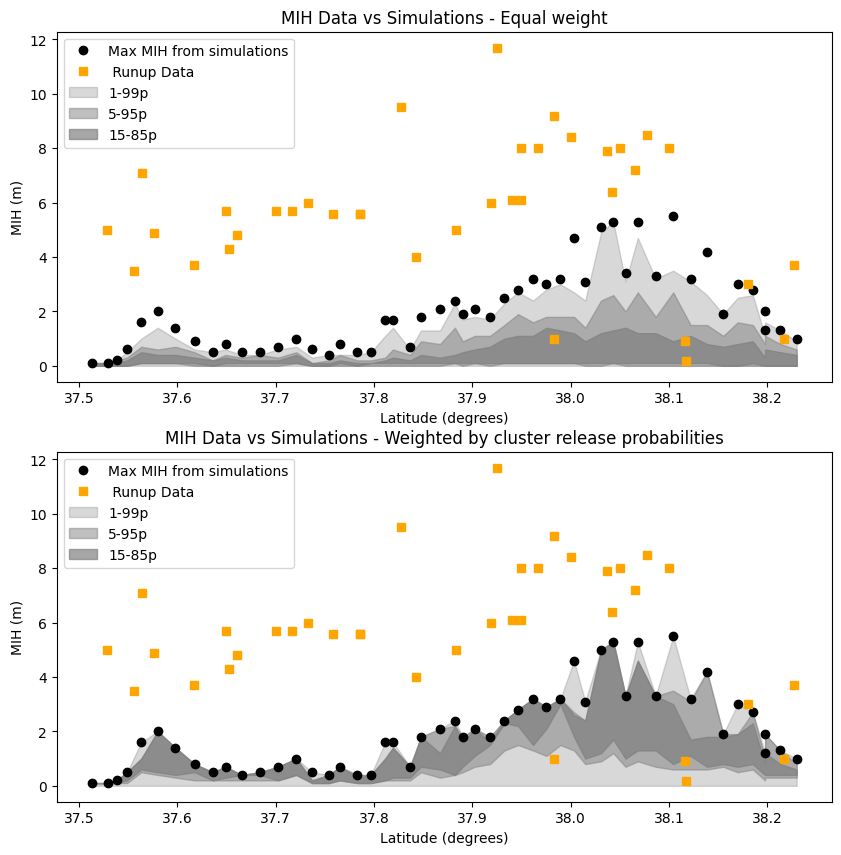

In [18]:
### Plot results
pois_to_plot = np.arange(50, 100, 1) # POIs 50 to 100 are along the East coast of Sicily

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)
plot_mih_percentiles(pois_coords, runup_data, MIH_perc_equal, pois_to_plot, ax, 'Equal weight')
plot_mih_percentiles(pois_coords, runup_data, MIH_perc_weighted, pois_to_plot, ax2,'Weighted by cluster release probabilities')

plt.show()